<center>

# Trabajo Práctico 2: EXTRACCIÓN DE CARACTERÍASTICAS

## Procesamiento Avanzado de Imágenes en Biomedicina y Biología

### Segundo Cuatrimestre 2024

<table>
      <tr>
        <th>Alumnos</th>
        <th>Legajos</th>
      </tr>
      <tr>
        <td>
          Bajlec, Ivo<br>
          Grau, Gonzalo Andrés<br>
          Neira, Lucas Matias
        </td>
        <td>
          62175<br>
          62259<br>
          61750<br>
        </td>
      </tr>
    </table>

**Docente**: Roberto Sebastián Tomás

**Fecha de entrega**: 07/09/2024

</center>

In [80]:
# Imports necesarios para el resto del archivo
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import pandas as pd
from skimage.transform import hough_circle
import ipywidgets as widgets
from IPython.display import display
from descrip_fourier_hu import *
from texturas import *
import time

%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


###  2- Analice y compare las imágenes img-1, img-2 e img-5contenidas en la carpeta: “PAIByB-4”


In [15]:
lista_paths = lista_de_paths(path_folder= 'PIByB_4')
lista_imagenes = []
for i in lista_paths:
    image = cv2.imread(i, cv2.IMREAD_GRAYSCALE)
    lista_imagenes.append(image)\
    


#### 2.1. Elija un contorno a analizar y compara los descriptores de forma de fourier y los momentos Hu. ¿Qué puede concluir de esta comparación?¿Cual de los métodos le resulto mejor para la extracción de características?

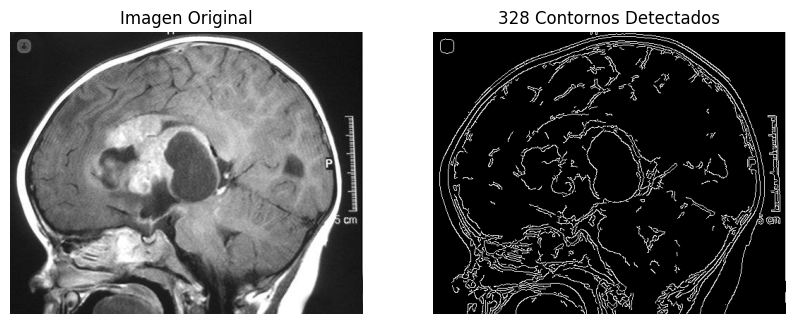

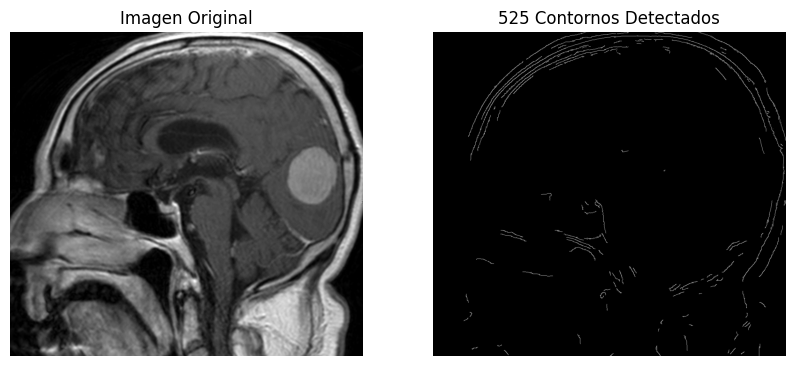

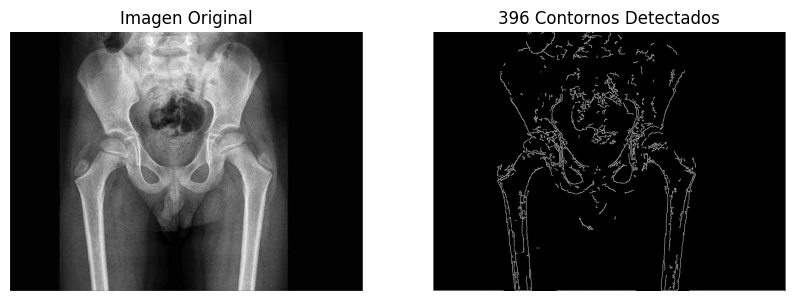

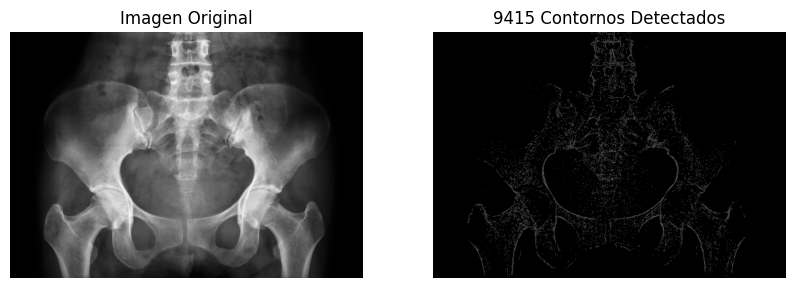

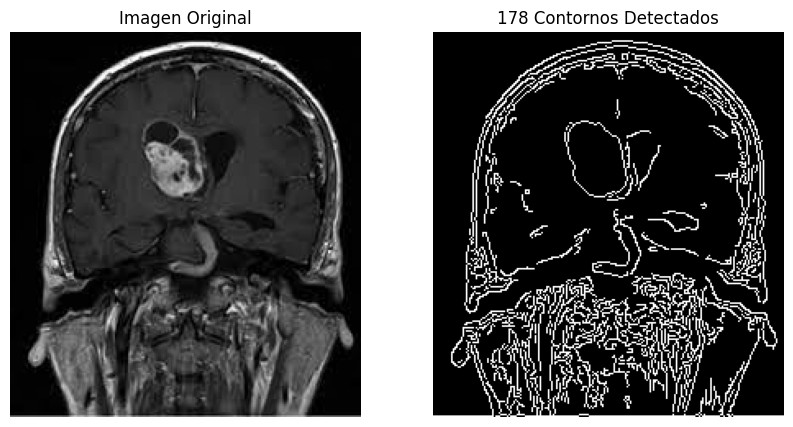

In [41]:
lista_max_contorno = []

for i in range (len(lista_imagenes)):
    if i == 1:
       contornos = Contornos(lista_imagenes[i],plot=True,upper_tresh=150,lower_tresh= 75)
    elif i == 3:
       contornos = Contornos(lista_imagenes[i],plot=True,upper_tresh=130,lower_tresh= 75,otsu= True)
    else :   
        contornos = Contornos(lista_imagenes[i],plot=True)
        #se agrega el contorno de mayor area cubierta, el mas grande 
    lista_max_contorno.append(max(contornos, key=cv2.contourArea))
    

para la imagen img-4.tif, se ve como ni siquiera usando una binarizacion por otsu que arroja un numero exorbitante de contornos, todos son muy diminutos

##### Imagen orignal y su contorno maximo


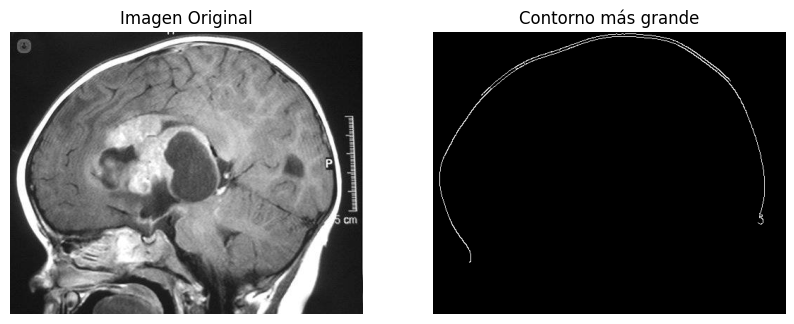

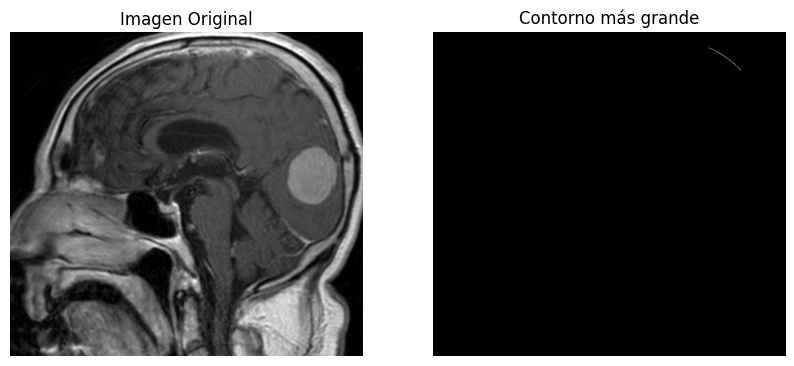

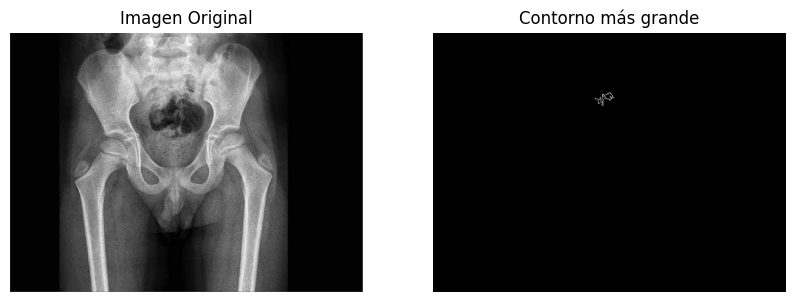

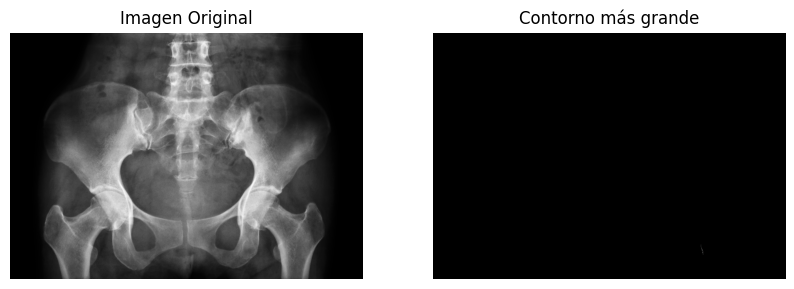

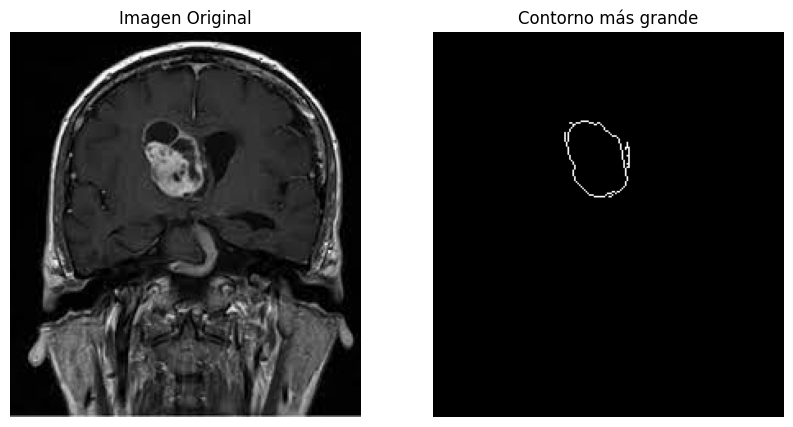

In [40]:
for j in range(len(lista_imagenes)):
    
    imagen_contornos = np.zeros_like(lista_imagenes[j])  # Imagen negra para dibujar los contornos
    # Dibuja el contorno más grande en una imagen vacía
    cv2.drawContours(imagen_contornos, [lista_max_contorno[j]], -1, 255, 1)  # 1 píxel de grosor, color blanco

    # Mostrar la imagen original y la imagen con los contornos
    plt.figure(figsize=(10, 5))
    
    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(lista_imagenes[j], cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    # Imagen con el contorno más grande
    plt.subplot(1, 2, 2)
    plt.imshow(imagen_contornos, cmap='gray')
    plt.title('Contorno más grande')
    plt.axis('off')

    # Mostrar el gráfico
    plt.show()

### Momentos de Hu

#### Se presentan los momentos de Hu para cada contorno maximo, en escala logaritmica 

In [46]:
# Inicializa una lista para almacenar los datos de cada imagen
datos_moments = []

# Recorre cada contorno y almacena los momentos de Hu en la lista
for k in range(len(lista_max_contorno)):
    dic = Hu_moments(contorno=lista_max_contorno[k], label=k + 1)
    
    # Extrae el label y los momentos de Hu
    label = dic['label']
    hu_values = dic['Hu_Moments']

    # Crea un diccionario para la fila del DataFrame
    fila = {'Imagen': label}
    # Agrega los momentos de Hu al diccionario
    fila.update(hu_values)

    # Agrega la fila al listado de datos
    datos_moments.append(fila)

# Crea el DataFrame de pandas
df_moments = pd.DataFrame(datos_moments)

# Asegúrate de que las columnas del DataFrame estén en el orden correcto
# Las columnas se agregarán automáticamente, pero aquí las enumeramos
df_moments = df_moments[['Imagen'] + [f'Hu_Moment_{i+1}' for i in range(7)]]

# Muestra el DataFrame
print(df_moments)

   Imagen  Hu_Moment_1  Hu_Moment_2  Hu_Moment_3  Hu_Moment_4  Hu_Moment_5  \
0       1    -1.769835    -3.194120    -4.920004    -4.853258    -9.445185   
1       2    -1.396253    -2.786694    -2.755729    -2.283181    -4.740766   
2       3     0.210040     0.724523     1.201143     0.908553     1.969334   
3       4     0.146349     0.375539     0.690021     0.750352     1.470543   
4       5     0.758825     2.361965     4.315824     5.768248    10.905516   

   Hu_Moment_6  Hu_Moment_7  
0    -6.163566     9.675270  
1    -3.378781    -4.499798  
2     1.289860     2.748085  
3     0.971093     3.779938  
4     7.090303    11.035148  


### Descriptores de Fourier 

#### se calcula la FFT del contorno y se eliminan las frecuencias intermedias 

In [56]:
list_filt_contornos = []
list_fourier_contor = []
list_fourier_contor_filt = []


for t in lista_max_contorno:
    # mantengo solo el 20% mas bajo y el 20% mas alto 
    contorno_fourier_filt, contorno_fourier = contorno2fourier(borde= t, porcentaje_descriptores= 0.2)

    list_fourier_contor.append(contorno_fourier)
    list_fourier_contor_filt.append(contorno_fourier_filt)

    contorno_recon = reconstruir_contorno(contorno_fourier = contorno_fourier,shift= True)
    list_filt_contornos.append(contorno_recon)


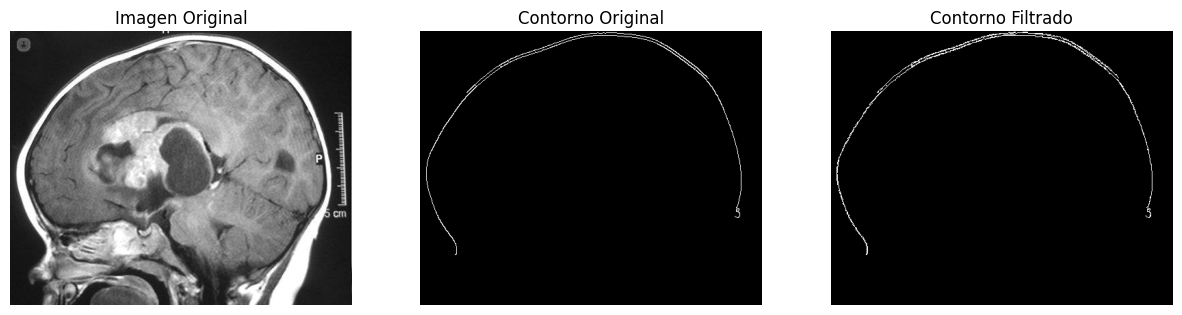

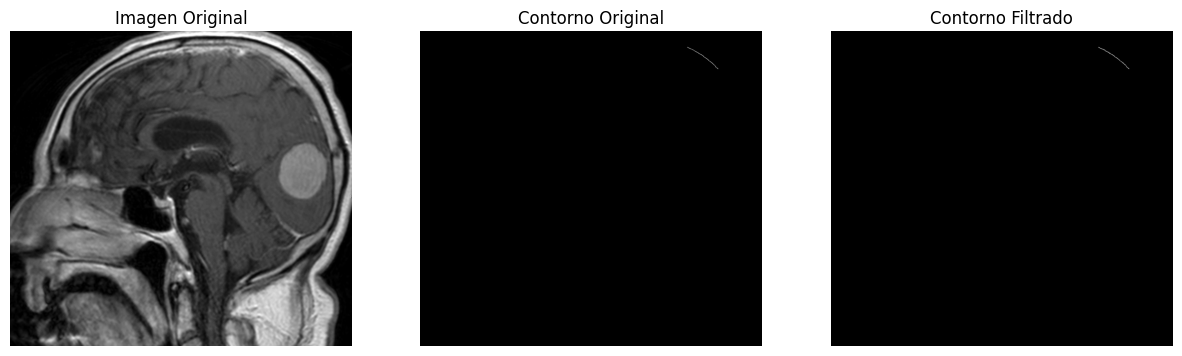

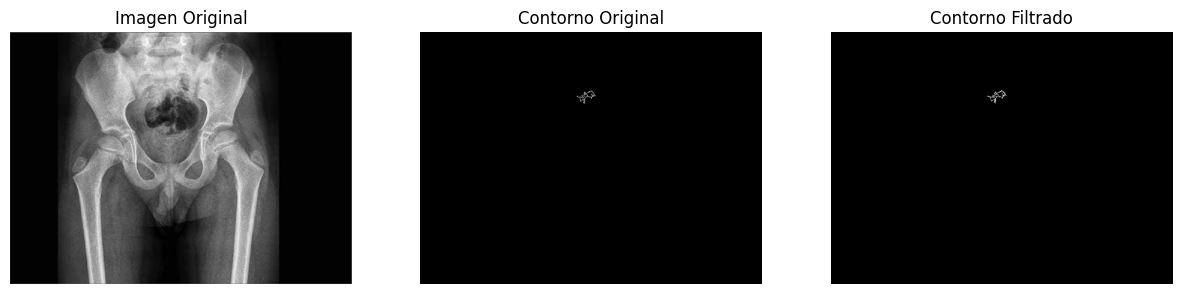

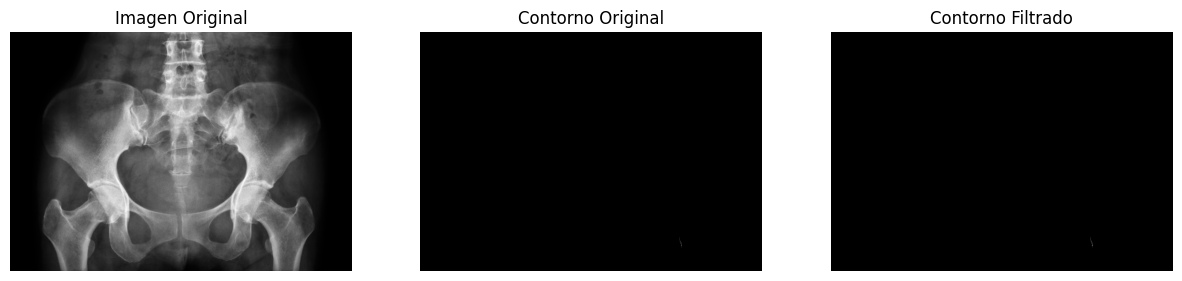

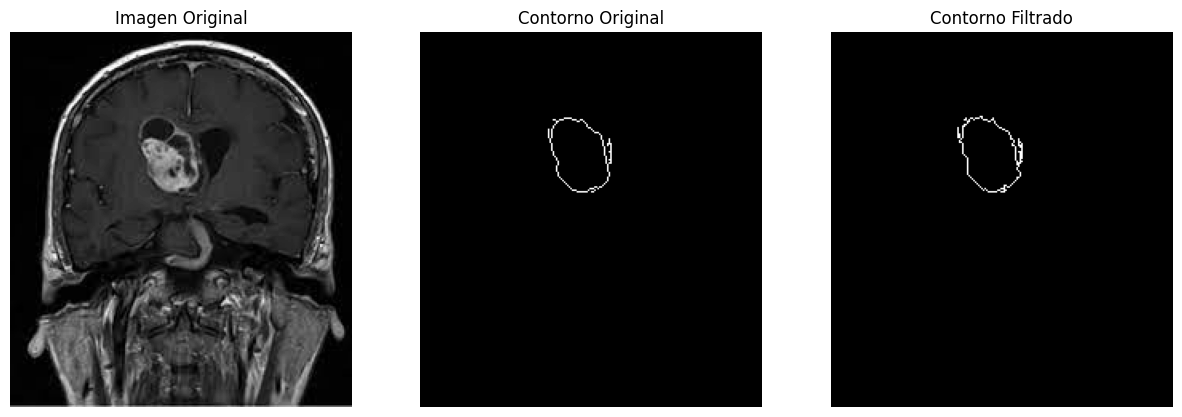

In [70]:
for j in range(len(lista_max_contorno)):
    # Crear la imagen negra para dibujar el contorno original
    imagen_contornos = np.zeros_like(lista_imagenes[j])  
    cv2.drawContours(imagen_contornos, [lista_max_contorno[j]], -1, 255, 1)  # Dibuja el contorno original

    # Crear la imagen negra para dibujar el contorno filtrado
    imagen_contornos_filt = np.zeros_like(lista_imagenes[j])
    cv2.drawContours(imagen_contornos_filt, [list_filt_contornos[j]], -1, 255, 1)  # Dibuja el contorno filtrado

    # Crear un nuevo gráfico para cada imagen
    plt.figure(figsize=(15, 5))  # Ancho mayor para acomodar las tres imágenes

    # Imagen original
    plt.subplot(1, 3, 1)
    plt.imshow(lista_imagenes[j], cmap='gray')
    plt.title('Imagen Original')
    plt.axis('off')

    # Imagen con el contorno original
    plt.subplot(1, 3, 2)
    plt.imshow(imagen_contornos, cmap='gray')
    plt.title('Contorno Original')
    plt.axis('off')

    # Imagen con el contorno filtrado
    plt.subplot(1, 3, 3)
    plt.imshow(imagen_contornos_filt, cmap='gray')
    plt.title('Contorno Filtrado')
    plt.axis('off')

    # Mostrar el gráfico
    plt.show()

### Conclusion:
Los momentos de Hu son utiles para brindar caracteristicas que son invariantes a las transformaciones. A su vez al ser solamente 7 por imagen son facilmente comparables. 
La transformada de fourier nos va a brindar una caracterización mucho mas minusiosa al poder apreciar el espctro de frecuencias, sin embargo es dificil de interpretar por el amplio rango que puede llegar a haber de estas. Ademas, no es invariante a transformaciones, para lograrloshay que seguir una serie de pasos: 

- Invarianza a traslación: Ignorar la frecuencia cero .
- Invarianza a rotación: Usar solo las magnitudes de los coeficientes de Fourier.
- Invarianza a escala: Normalizar los coeficientes dividiéndolos por la magnitud del primer coeficiente.

Sin embargo, luego de realizarlo los resultados no fueron prometedores, por lo cual se concluye que Hu tiene menos capacidad de información, pero la compensa en invarianza,

### 2.2 Analice las texturas del contorno elegido mediante filtros Gabor, transformada de Fuorier y transformada wavelet. ¿Puede caracterizar de forma única la textura de los objeto mediante los métodos utilizados?¿Qué puede decir de los valores obtenidos para cada imagen? 

#### Gabor


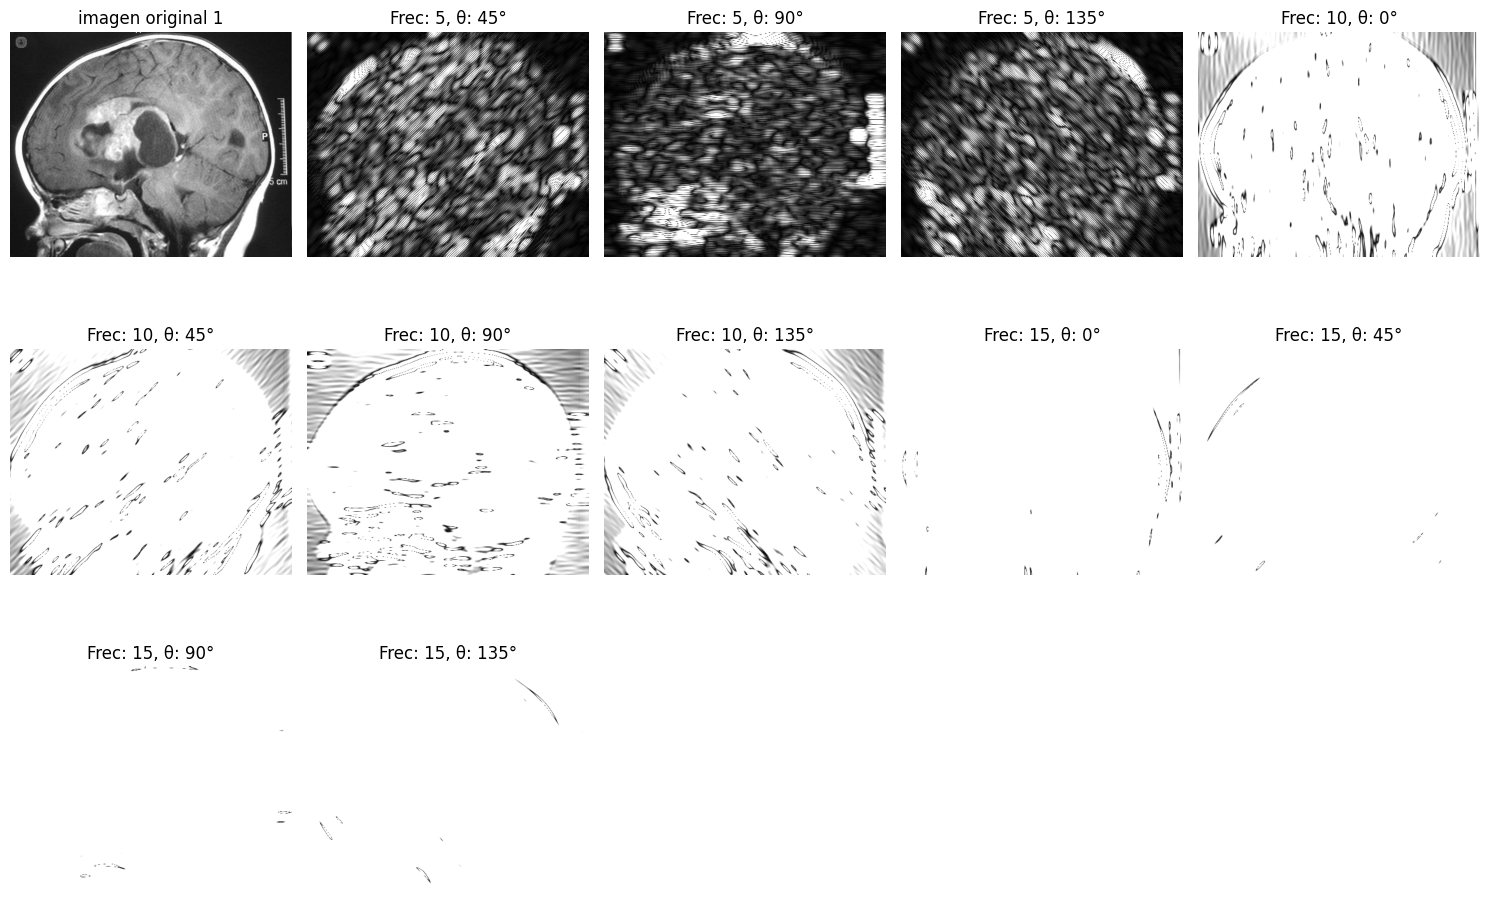

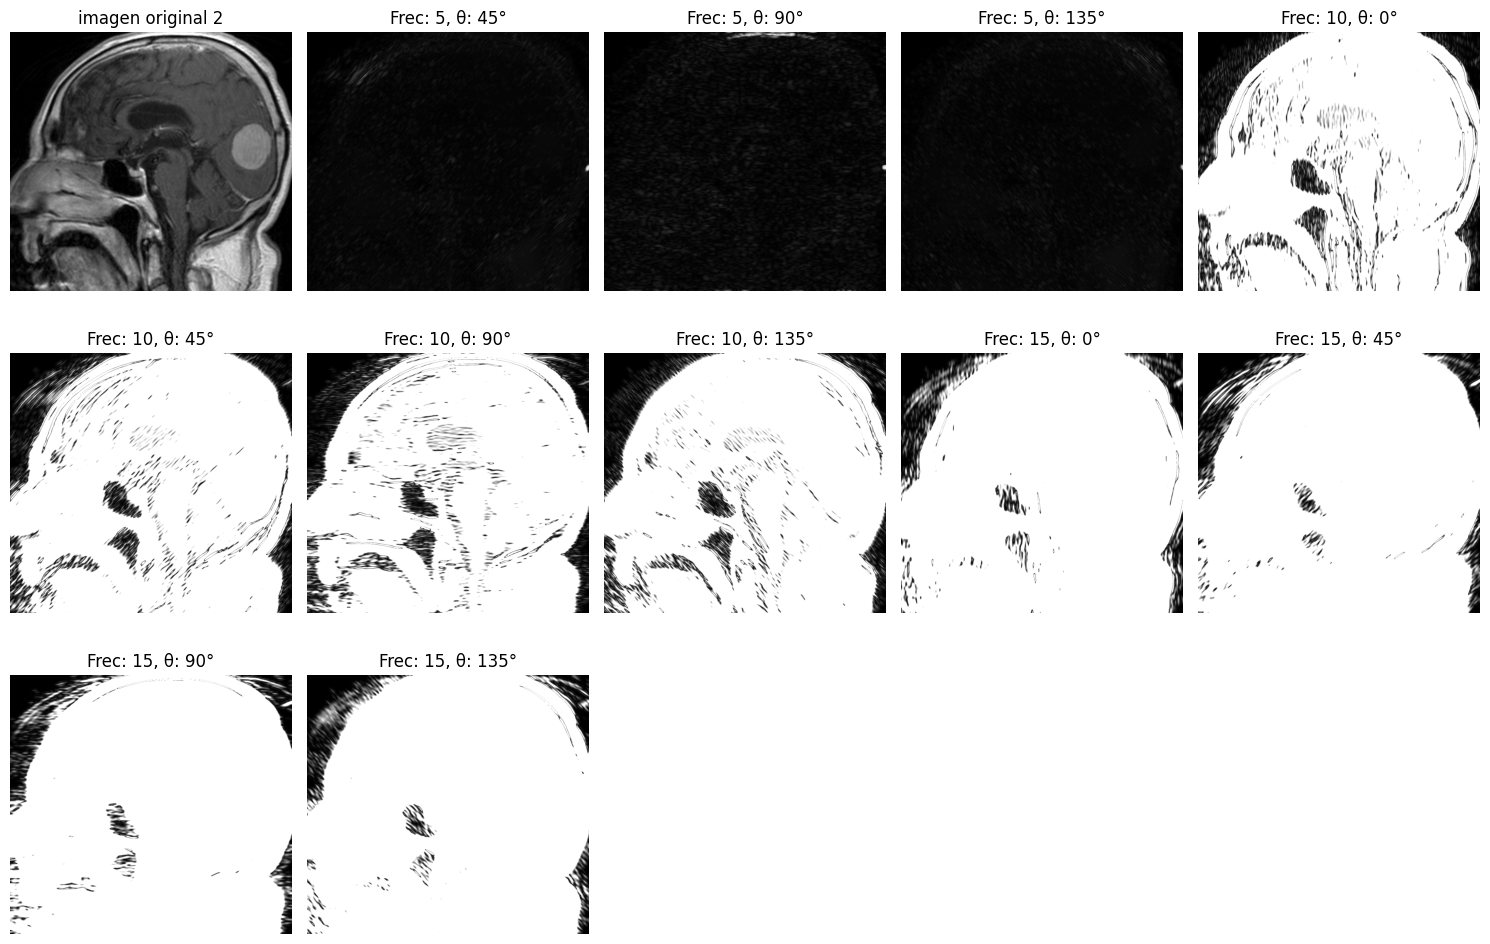

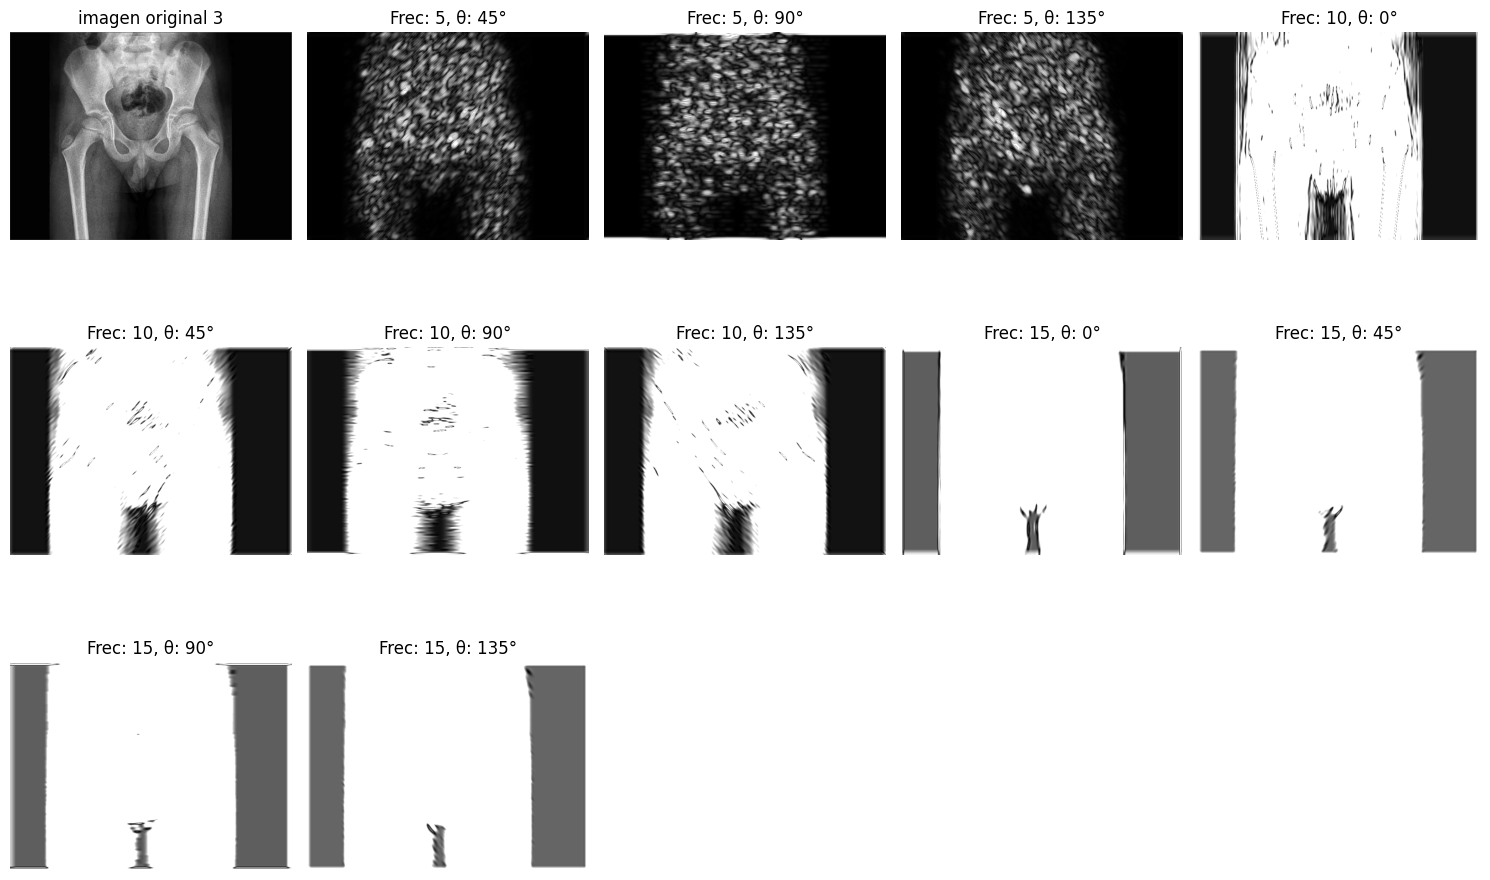

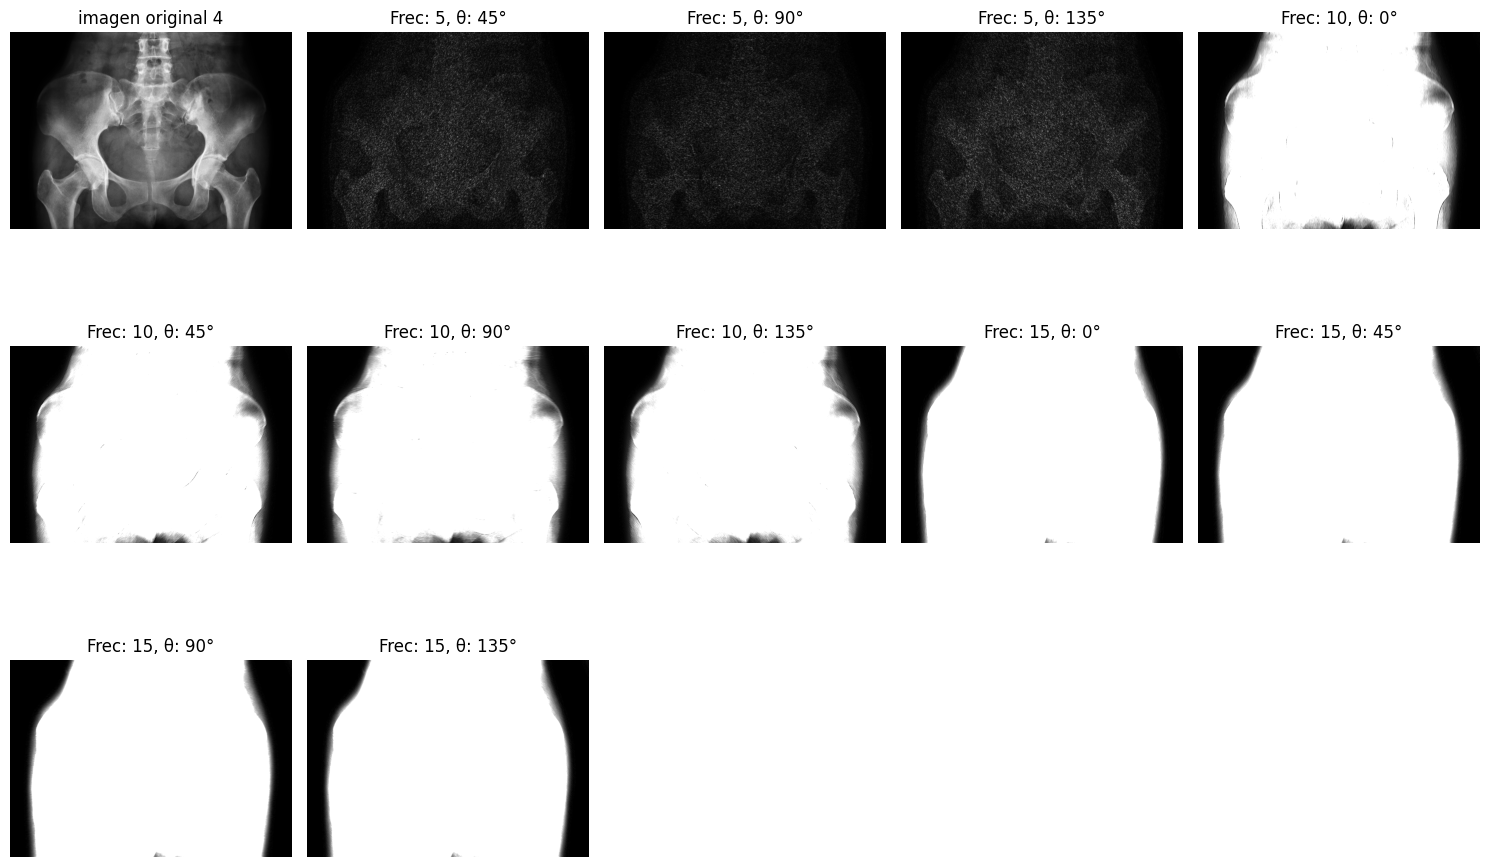

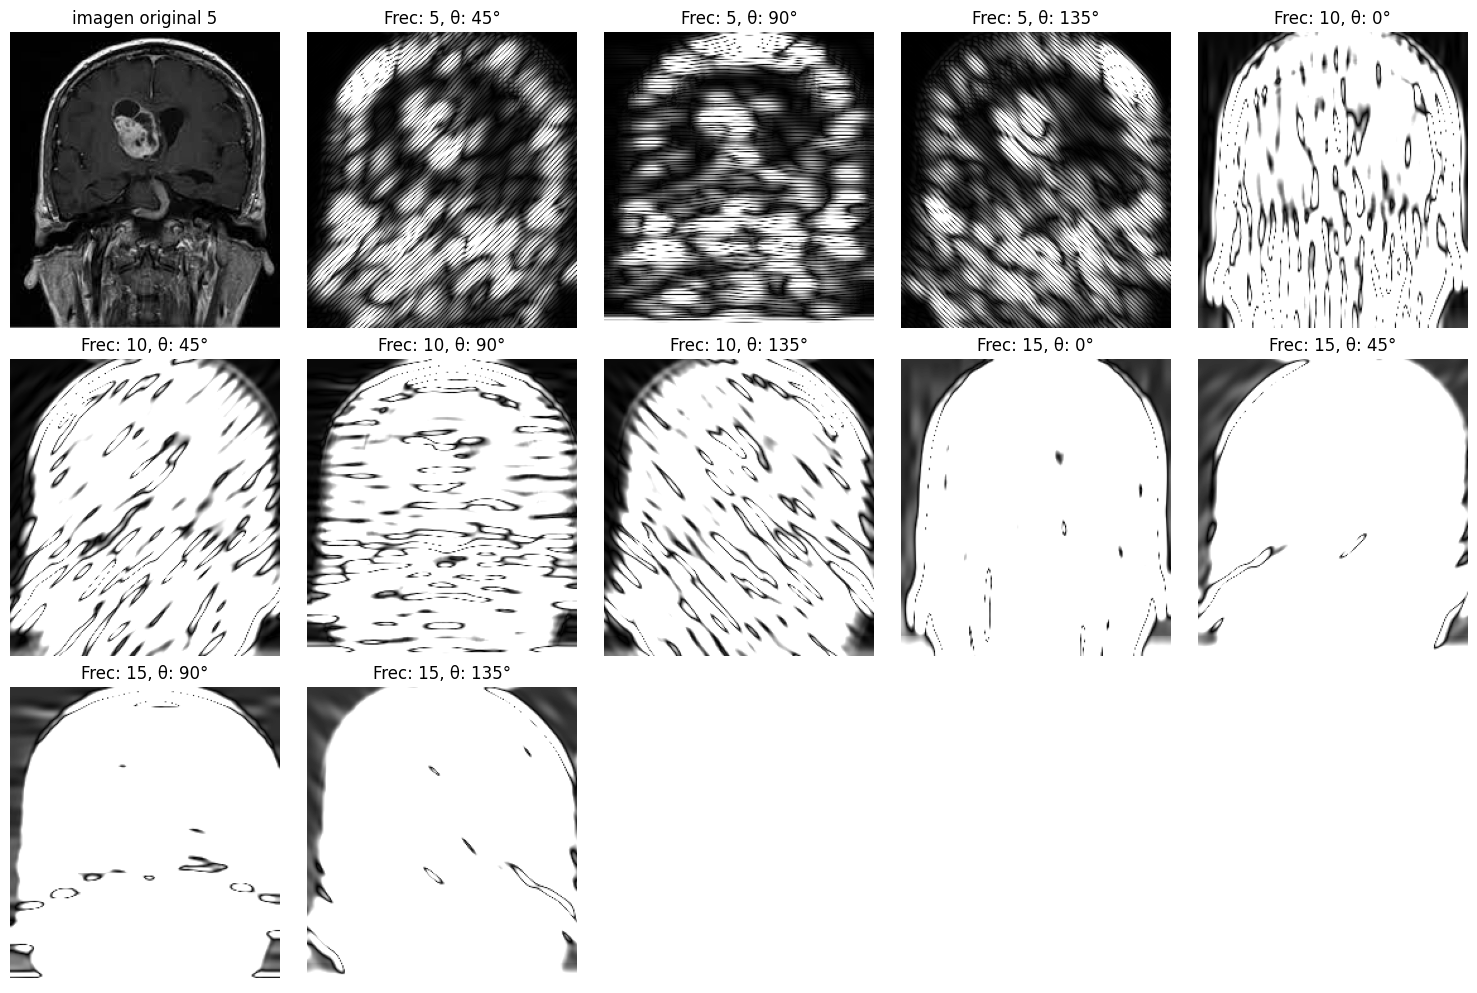

    Image  Frequency  Orientation        Mean      Variance
0       1          5     0.000000   73.325585   5236.751989
1       1          5     0.785398   80.695030   5658.794423
2       1          5     1.570796   71.579325   5250.427768
3       1          5     2.356194   74.654565   4982.441460
4       1         10     0.000000  239.168600   1717.855774
5       1         10     0.785398  244.463455   1171.011804
6       1         10     1.570796  239.545435   1613.502776
7       1         10     2.356194  244.944985   1093.377168
8       1         15     0.000000  254.114500    148.779040
9       1         15     0.785398  254.646265     60.311367
10      1         15     1.570796  254.771770     39.267191
11      1         15     2.356194  254.728020     45.114457
12      2          5     0.000000    9.828296    105.304924
13      2          5     0.785398    8.168738     61.540642
14      2          5     1.570796    9.932381    179.194051
15      2          5     2.356194    7.9

In [72]:

orient = [0, np.pi/4, np.pi/2, 3*np.pi/4]
frec = [5, 10, 15]


list_df = []


for idx, imagen in enumerate(lista_imagenes):
    plt.figure(figsize=(15, 10))
    subplot_idx = 1
    
   
    for freq in frec:
        for theta in orient:
            
            gabor_filtered = imagen_gabor(imagen=imagen, ksize=31, sigma=4.0, theta=theta, lambd=freq, gamma=0.5, ps=0)
            
            
            m_val, var_val = caracteristicas_gabor(gabor_filtered)
            
           
            data = {'Image': idx + 1, 'Frequency': freq, 'Orientation': theta, 'Mean': m_val, 'Variance': var_val}
            list_df.append(data)
            
           
            plt.subplot(len(frec), len(orient) + 1, subplot_idx)
            plt.imshow(gabor_filtered, cmap='gray')
            plt.title(f'Frec: {freq}, θ: {round(np.degrees(theta))}°')
            plt.axis('off')
            
            subplot_idx += 1
    
    
    plt.subplot(len(frec), len(orient) + 1, 1)
    plt.imshow(imagen, cmap='gray')
    plt.title(f'imagen original{idx + 1}')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Convert list of dictionaries to DataFrame
df = pd.DataFrame(list_df)
print(df)

### Fourier

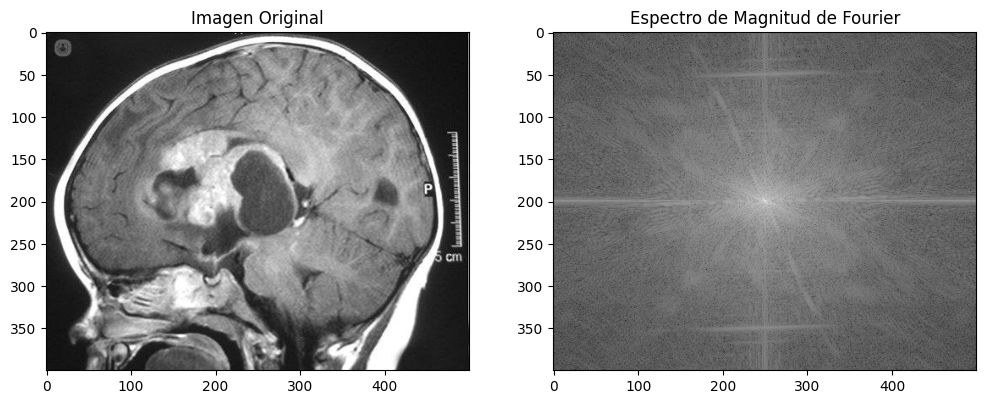

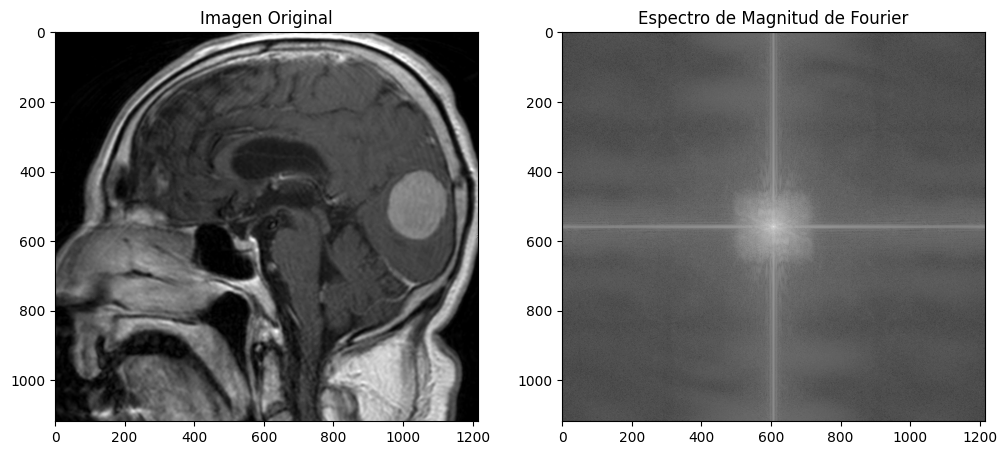

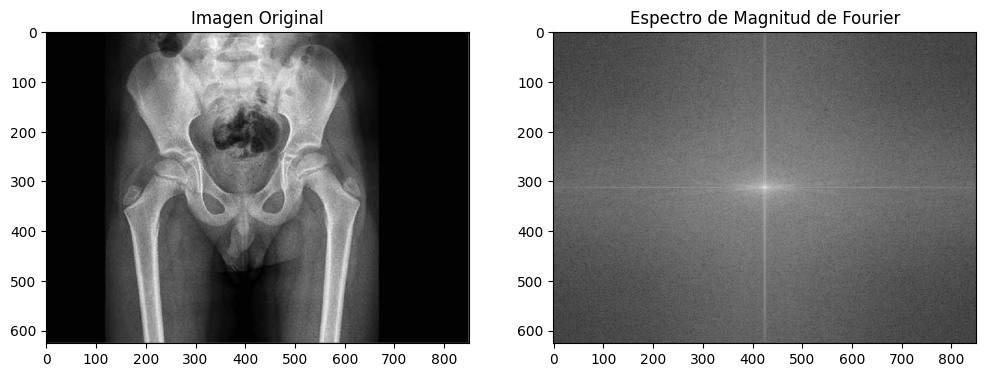

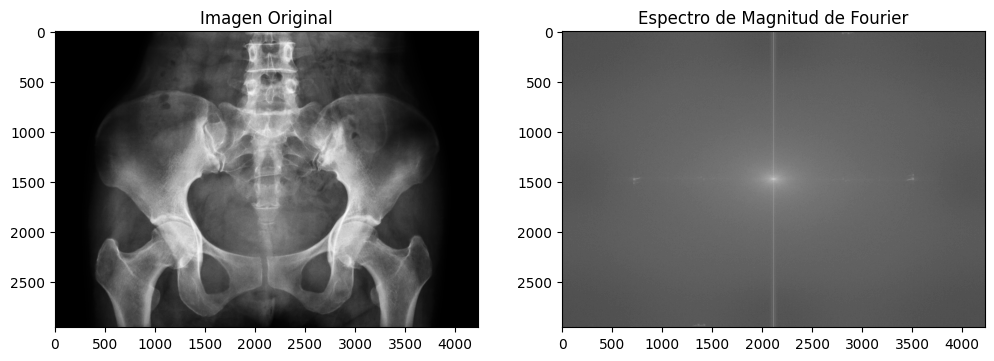

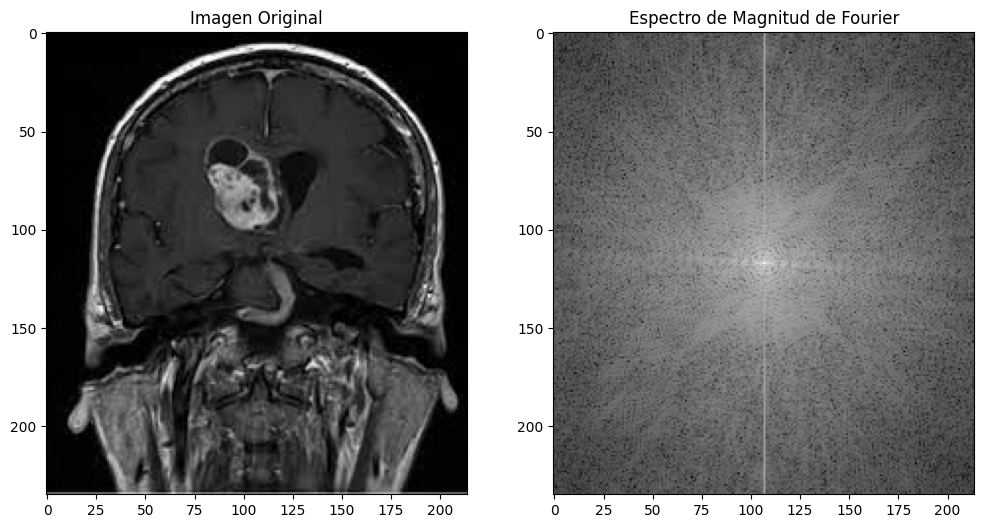

   Energía Total  Energía Primer Cuadrante  Energía Segundo Cuadrante  \
0   1.323305e+09              3.080927e+08               3.186818e+08   
1   6.782969e+09              1.636938e+09               1.629809e+09   
2   2.428679e+09              5.500699e+08               5.772328e+08   
3   1.090502e+11              2.671635e+10               2.651326e+10   
4   2.084909e+08              4.966229e+07               5.096358e+07   

   Energía Tercer Cuadrante  Energía Cuarto Cuadrante    Imagen  
0              3.312474e+08              3.652832e+08  Imagen 1  
1              1.628328e+09              1.887894e+09  Imagen 2  
2              6.222347e+08              6.791413e+08  Imagen 3  
3              2.683736e+10              2.898322e+10  Imagen 4  
4              4.979294e+07              5.807207e+07  Imagen 5  


In [75]:
resultados_totales = []

# Iterar sobre cada imagen, calcular las características y mostrar el gráfico
for i, imagen in enumerate(lista_imagenes):
    resultados, f_shift = caracteristicas_fourier(imagen, plot=True)
    
    # Añadir los resultados al dataframe
    resultados['Imagen'] = f'Imagen {i+1}'
    resultados_totales.append(resultados)

# Convertir los resultados a un DataFrame
df_resultados = pd.DataFrame(resultados_totales)

# Mostrar el DataFrame
print(df_resultados)

### Wavelets

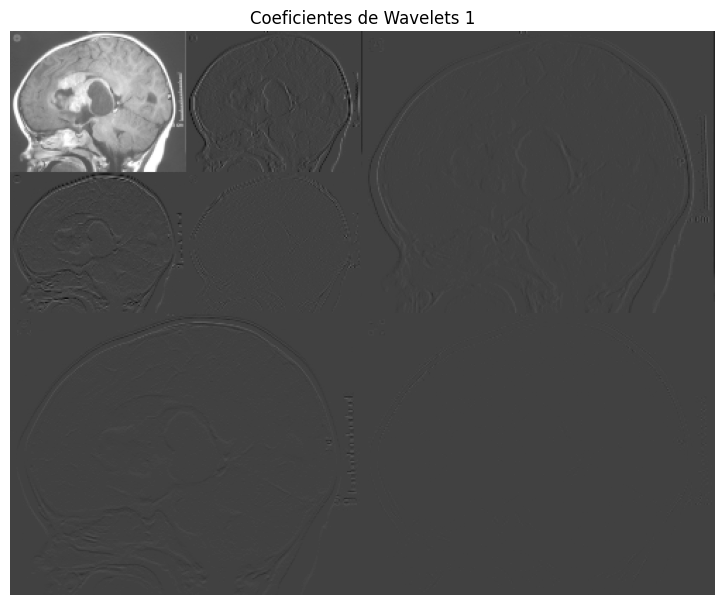

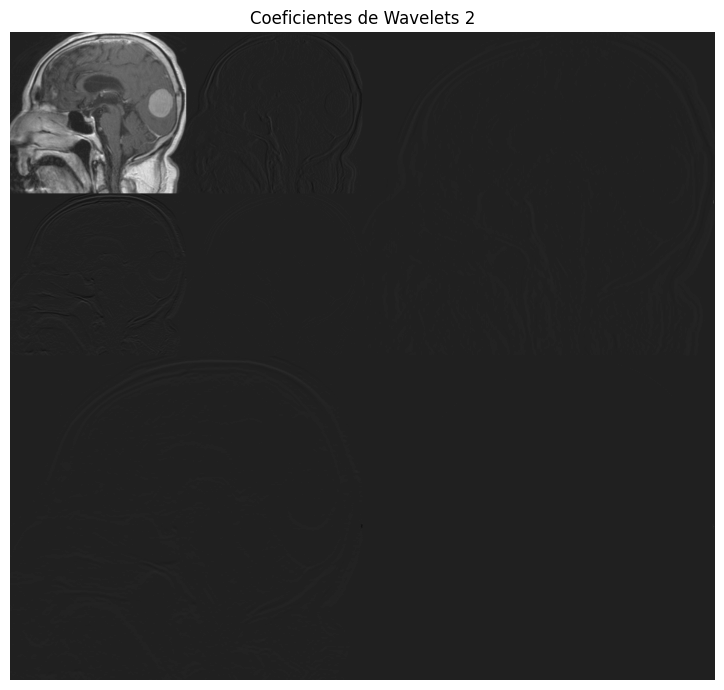

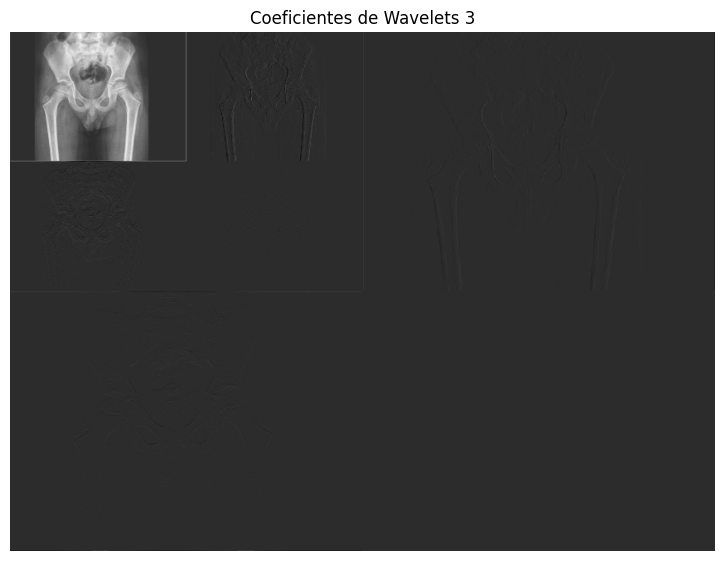

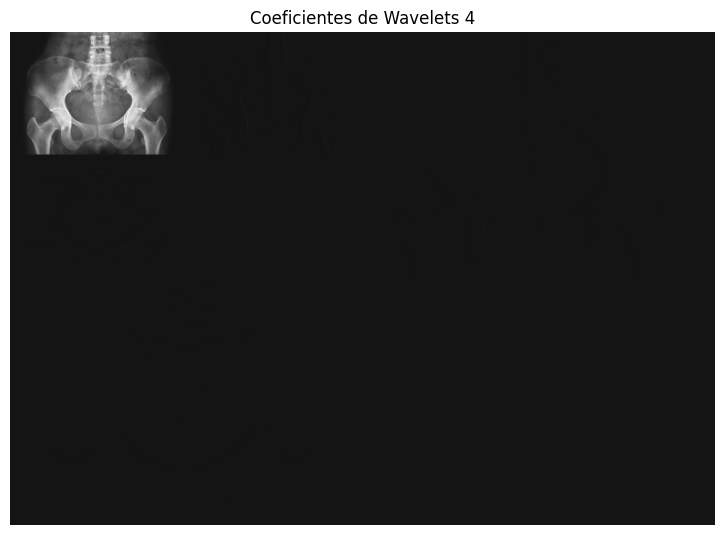

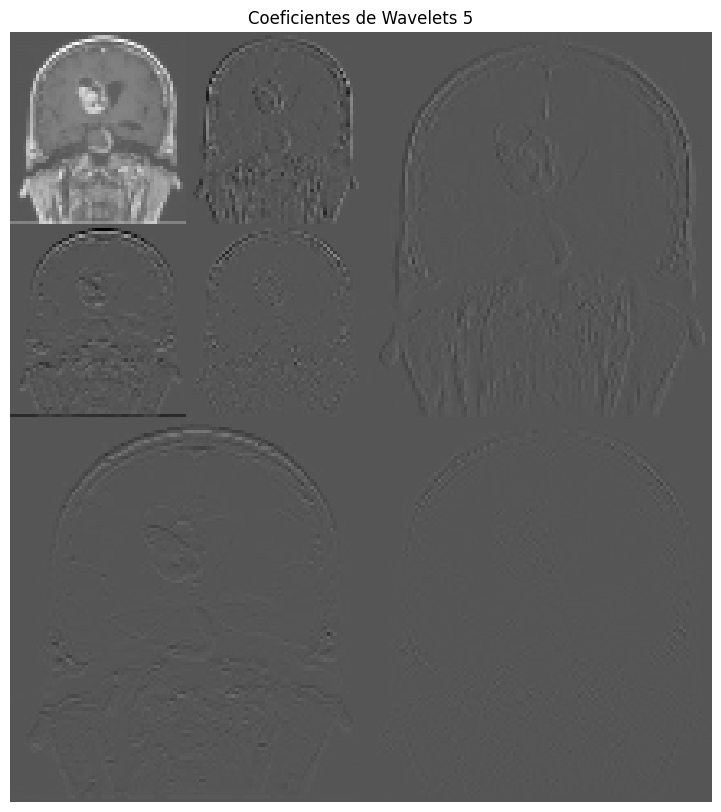

   Energía Aproximación  Nivel 1 Energía Horizontal  Nivel 1 Energía Vertical  \
0          3.230159e+09                1.578598e+07              2.174606e+07   
1          1.084720e+10                1.642527e+07              1.335516e+07   
2          4.707302e+09                6.731240e+06              9.845419e+06   
3          9.457249e+10                1.573401e+07              2.176720e+07   
4          1.812820e+08                7.977980e+06              7.163678e+06   

   Nivel 1 Energía Diagonal  Nivel 2 Energía Horizontal  \
0              3.260671e+06                  8641707.75   
1              2.633725e+05                  3995607.50   
2              1.299261e+06                  5108434.75   
3              4.844935e+06                 10413449.75   
4              2.033325e+06                  3728769.00   

   Nivel 2 Energía Vertical  Nivel 2 Energía Diagonal    Imagen  
0               13394275.75                 933583.75  Imagen 1  
1                3227665.5

In [83]:
# Lista para almacenar los resultados de wavelets de todas las imágenes
resultados_totales_wavelets = []

# Iterar sobre cada imagen, aplicar la transformada wavelets y mostrar el gráfico
for i, imagen in enumerate(lista_imagenes):
    # Aplicar wavelets y extraer características
    resultados_wavelets, coef_wavelets = caracteristicas_wavelets(imagen,  Plot_all_levels=False)

    # Añadir información del número de imagen
    resultados_wavelets['Imagen'] = f'Imagen {i+1}'

    # Almacenar los resultados
    resultados_totales_wavelets.append(resultados_wavelets)

    # Ploteo de la imagen original y los coeficientes de wavelets
    plt.figure(figsize=(20, 10))
    
    # Imagen original
    plt.subplot(1, 2, 1)
    plt.imshow(imagen, cmap='gray')
    plt.title(f'Imagen Original {i+1}')
    plt.axis('off')
    
    # Coeficientes de wavelets (nivel)
    coeff_arr, _ = pywt.coeffs_to_array(coef_wavelets)
    plt.imshow(coeff_arr, cmap='gray')
    plt.title(f'Coeficientes de Wavelets {i+1}')
    plt.axis('off')
    
    plt.show()

# Convertir los resultados en un DataFrame
df_wavelets = pd.DataFrame(resultados_totales_wavelets)

# Mostrar el DataFrame con las características extraídas
print(df_wavelets)

### Conclusión

- Se puede ver como Gabor presenta una herramienta muy personalizable para la deteccion de caracteristicas segun orientacion y frecuencia, ya que se pueden elegir a gusto estos parametros. A su vez se pueden modificar otros para obtener mejores resultados como lo es el parametro sigma o el gamma, para ajustar la presición del filtro. 
- Wavelets es uan herramienta que cuenta con los aspectos de orientacion y frecuencias, pero no tan personalizable como gabor. Se puede saber que en cada nivel de wavelets se extraen caracteristicas de detalles mas finos, pero no una frecuencia puntual ni una orientación personalizable. 
- Fourier si bien es la base de wavelets y gabor, justamnet por esto radica en una ausencia completa del parametro de orientación, solo pudendo apreciar las frecuencias en la imagen, lo cual dará una informacion más general y no tan puntillosa en una dirección particular a la hora de extraer caracteristicas.